 # Get weather data for Ireland and plot load data v wx variables etc

In [29]:
# import  module containing all my functions 
import mscprojectcoding.FM_MScProject_LoadForecasting_Module as FMmodule


In [30]:
# force reimport of module after edits/updates to functions in PyCharm 
import importlib
importlib.reload(FMmodule)

<module 'mscprojectcoding.FM_MScProject_LoadForecasting_Module' from 'c:\\users\\fmurphy\\onedrive - loughborough university\\fm-project\\mscprojectcoding\\src\\mscprojectcoding\\FM_MScProject_LoadForecasting_Module.py'>

In [31]:
#import required  functions  .. 

from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  fullprint                  #change num lines to print of a numpy array without changing default
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_NaN_stats              # get stats for NaNs in each column
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_limits                 # get x,y limits for plot axis
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_uniques                # get unique values from dataframe columns or pd.series?
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  peristModelPlot            # plot persistence model series
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  persistScatterPlot         # plot peristance models 
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  piecewise_linear           # comput piecewise linear function given slopes, intercept etc
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  PlotLoadByDaysOfWeek       # plot load profiles for weekdaysd, sat, sun 
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  plotSectionOfLoadProf      # redundant? used in MLR scripts
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  pltDefaults                # set rc params (matplotlib) plot defaults
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  round_down                 # round a number down to nearest decade (0.1,1,10,100 etc) 
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  round_up                   # round a number up to nearest decade (0.1,1,10,100 etc)
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  show_mem_usage             # shows total memory usage
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  setColMap                  # get colmap given data range

In [32]:
# may not need all these..

import matplotlib.pyplot as plt     # pyplot = collection of command style functions that make matplotlib work like MATLAB, uses numpy arrays internally
import matplotlib.colors as colors2  # module for converting numbers or color arguments to RGB or RGBA
import matplotlib.cm as cmx         # built-in colour maps and utilities; Any colormap can be reversed by appending '_r', so 'RdYlGn_r' is the reversed Red-Yellow-Green colormap
import matplotlib.mlab as mlab      # matlab compatible cmd names
import matplotlib.ticker as mtick   # configurable tick locating and formatting, used by Axis class
import matplotlib.dates as mdates    # useful for getting tick label as siimple dates

import matplotlib.patches as mpatches  # draw geometric shapes 
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines      # 2D lines
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,MaxNLocator) # needed for eg integer tick marks etc

import seaborn as sns                  # data visualization library based on matplotlib             

%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, 'grid.linewidth': 0.})

import math                            # module provides access to the mathematical functions defined by the C standard
import csv
import sys
import pandas as pd
import numpy as np
import time                 
import re                              # provides regular expression matching operations 
import random

from six.moves import cPickle as pickle   # cPickle is faster as written in C but merged with Pickle in Python 3.x ..

import numpy.polynomial.polynomial as poly  # polynomial functions incl fitting , etc

from sklearn.cluster import KMeans    # Sklearn = SciPy ML toolkit 
from sklearn import linear_model            # Estimated coefficients for linear regression

from scipy.interpolate import interp1d      # Interpolate a 1-D function.
from scipy.spatial.distance import cdist, pdist       # Pairwise distances between observations in n-dimensional space.
from scipy.spatial.distance import squareform         # Convert a vector-form distance vector to a square-form distance matrix, and vice-versa
from scipy.cluster.hierarchy import dendrogram, linkage   # hierarchical/agglomerative clustering 
from scipy.cluster.hierarchy import fcluster              # Form flat clusters from the hierarchical clustering
from scipy import stats                                   # statistical functions https://docs.scipy.org/doc/scipy/reference/stats.html
from scipy import optimize             # commonly used optimization algorithms eg least squares minimization, curve fitting , etc

import json
from datetime import datetime, timedelta 

from itertools import chain           # for iterating through list (of lists) of dictionaries etc

import requests                              # url requests


In [33]:
# to avoid warning message 
#C:\Users\fmurphy\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [34]:
# override some default print parameters
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth',None)

#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=2000)
np.set_printoptions(edgeitems=10)


In [35]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*(x-x0)+y0, lambda x:k2*(x-x0)+y0])  # lambda function

In [36]:
# set date window of interest
start='1/1/2010'
end='1/1/2011'


In [37]:
# create date df from start to end date
colsD = pd.date_range(start, end, freq='1D')[0:-1]  # returns DatetimeIndex
dates = colsD.date
dates   # ndarray
#colsD   # DatetimeIndex
len(dates)

365

In [38]:
# set lat, long for Rep of Ireland - no location data for smart meters - 
# originaly used simple avg location ~ Limerick 52.5° N, 8.5° W
# but decided to swicth to loaction of Wx obs at Phoeniz park, Dublin 
#latitude = 52.5
#longitude = -8.5
latitude = 53.360001
longitude = -6.325000




In [39]:
# get length of day 

from astral import LocationInfo                       # for sunrise and sunset 
from astral.sun import sun  
import pytz
from pytz import timezone


city = LocationInfo("Dublin", "Ireland", "Europe/London", latitude, longitude)

print((
f"Information for {city.name}/{city.region}\n"
f"Timezone: {city.timezone}\n"
f"Latitude: {city.latitude:.02f}; Longitude: {city.longitude:.02f}\n"
))

j=0
dayLight = np.zeros(len(dates))   # nparray  to hold legth of daylight , etc
sunset = np.zeros(len(dates))

for j,ind in enumerate(dates):      
    s = sun(city.observer, date=dates[j],tzinfo=city.timezone)
    #print(f'Dawn: {s["dawn"]} ',f'Dusk: {s["dusk"]}',f'Sunset:{s["sunset"]}')  
    dayLight[j] = (s["dusk"]-s["dawn"]).seconds/3600
    sunset[j] = s["sunset"].hour + (s["sunset"].minute)/60 + (s["sunset"].second)/3600   # get sunset as decimal TZ(UTC) hr

#sunset



Information for Dublin/Ireland
Timezone: Europe/London
Latitude: 53.36; Longitude: -6.33



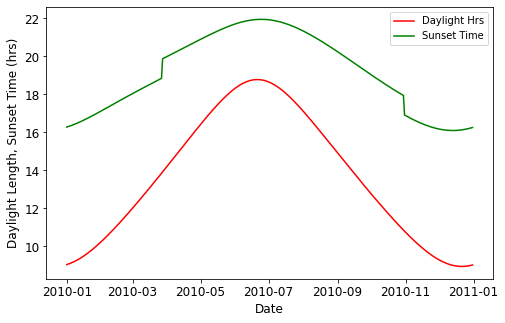

In [40]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax1.plot(dates, dayLight, color='r',label='Daylight Hrs')    
ax1.plot(dates, sunset, color='g',label='Sunset Time')  

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Daylight Length, Sunset Time (hrs)', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend()

In [41]:
# get weather data from Darksky

# first generate date df (in day steps - can retrieve weather for full day with one api call)
colsD = pd.date_range(start, end, freq='D',tz='UTC')[0:-1]
colsD

DatetimeIndex(['2010-01-01 00:00:00+00:00', '2010-01-02 00:00:00+00:00',
               '2010-01-03 00:00:00+00:00', '2010-01-04 00:00:00+00:00',
               '2010-01-05 00:00:00+00:00', '2010-01-06 00:00:00+00:00',
               '2010-01-07 00:00:00+00:00', '2010-01-08 00:00:00+00:00',
               '2010-01-09 00:00:00+00:00', '2010-01-10 00:00:00+00:00',
               ...
               '2010-12-22 00:00:00+00:00', '2010-12-23 00:00:00+00:00',
               '2010-12-24 00:00:00+00:00', '2010-12-25 00:00:00+00:00',
               '2010-12-26 00:00:00+00:00', '2010-12-27 00:00:00+00:00',
               '2010-12-28 00:00:00+00:00', '2010-12-29 00:00:00+00:00',
               '2010-12-30 00:00:00+00:00', '2010-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=365, freq='D')

# skip next bit - go down to read saved pickle file of weather data 

In [31]:
# run darksky api requests - up to 1000/day allowed for free

import requests
import json

api_key = '1adbda73f2fdc9e6436e4ddfec29341a'   # my account private key (Feargal Murphy )

# Pls notify (feargalemurphy@gmail.com) me if this needs to be used again as I may use myself from time to time.
# It seems Darksky has been bought by Google or MS?  so access may change..

#df_wxDarksky=pd.DataFrame()  
list_wxDarksky=[]

for j in range(0,365):
    dtime=colsD.values[j].astype('datetime64[s]')     # get datetime of midnight for day j
    #dtime=df_LocDateTime.time[j]        # get unix time of 2013-01-01 00:00:00.0 UTC
    print(dtime)

    #url = 'https://api.darksky.net/forecast/%s/%f,%f,%d?units=si&exclude=currently,flags' % (api_key,latitude,longitude,dtime)  # if UNIX time
    url = 'https://api.darksky.net/forecast/%s/%f,%f,%s?units=si&exclude=currently,flags' % (api_key,latitude,longitude,dtime)   # if datetime64 
    print(url)

    response = requests.get(url)
    weather_data = response.json()
    #print(weather_data['hourly']['data'])
    #df_wxDarksky = pd.concat([df_wxDarksky,pd.DataFrame(weather_data['hourly']['data'])],axis=0)
    list_wxDarksky.append((weather_data['hourly']['data']).copy())   # append list of 24 dictionaries (1 for each hr in day) for day

list_wxDarksky

2010-01-01T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-01T00:00:00?units=si&exclude=currently,flags
2010-01-02T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-02T00:00:00?units=si&exclude=currently,flags
2010-01-03T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-03T00:00:00?units=si&exclude=currently,flags
2010-01-04T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-04T00:00:00?units=si&exclude=currently,flags
2010-01-05T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-05T00:00:00?units=si&exclude=currently,flags
2010-01-06T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-06T00:00:00?units=si&exclude=currently,flags
2010-01-07T00:00:00
https://api.darksky.net/fo

[[{'time': 1262304000,
   'summary': 'Mostly Cloudy',
   'icon': 'partly-cloudy-night',
   'precipIntensity': 0,
   'precipProbability': 0,
   'temperature': 0.26,
   'apparentTemperature': -2.85,
   'dewPoint': -0.09,
   'humidity': 0.97,
   'pressure': 1008.4,
   'windSpeed': 2.64,
   'windGust': 2.64,
   'windBearing': 300,
   'cloudCover': 0.64,
   'uvIndex': 0,
   'visibility': 6.994},
  {'time': 1262307600,
   'summary': 'Mostly Cloudy',
   'icon': 'partly-cloudy-night',
   'precipIntensity': 0,
   'precipProbability': 0,
   'temperature': -0.95,
   'apparentTemperature': -4.3,
   'dewPoint': -1.22,
   'humidity': 0.98,
   'pressure': 1008.3,
   'windSpeed': 2.64,
   'windGust': 2.64,
   'windBearing': 305,
   'cloudCover': 0.84,
   'uvIndex': 0,
   'visibility': 10.003},
  {'time': 1262311200,
   'summary': 'Clear',
   'icon': 'clear-night',
   'precipIntensity': 0,
   'precipProbability': 0,
   'temperature': -2.07,
   'apparentTemperature': -5.96,
   'dewPoint': -2.96,
   'hum

In [42]:
# convert darksky weather data to dataframe and save as pickle in case need full dataset again
# from itertools import chain   # imported at top
#df_wxDarksky = pd.DataFrame(list(chain.from_iterable(list_wxDarksky)))
#df_wxDarksky.to_pickle('./intermediateData_Ireland/Dublin_df_wxDarksky.pkl')

### restart here

In [43]:

# read wx data from pickle file
df_wxDarksky = pd.read_pickle('../project_data/intermediateDataIreland/Dublin_df_wxDarksky.pkl')

In [44]:
#dtypes = { 'summary':'category','icon':'category','precipIntensity':'float32','precipProbability':'float32',\
#           'temperature':'float32','apparentTemperature':'float32','dewPoint':'float32','humidity':'float32',\
#           'pressure':'float32','windSpeed':'float32','windBearing':'float32','cloudCover':'float32',\
#           'uvIndex':'float32','visibility':'float32','precipType':'category','precipAccumulation':'float32' }

dtypes = { 'temperature':'float32','apparentTemperature':'float32','dewPoint':'float32','humidity':'float32',\
           'pressure':'float32','windSpeed':'float32','windGust':'float32','windBearing':'float32','cloudCover':'float32',\
           'uvIndex':'float32','visibility':'float32' }

date_col = ['date_time']



In [45]:
df_wxDarksky = df_wxDarksky.astype(dtype=dtypes)

In [46]:
# set datetime index from POSIX time 
df_wxDarksky['date_time'] = pd.to_datetime(df_wxDarksky['time'],unit='s')
df_wxDarksky['date_time'] = df_wxDarksky['date_time'].dt.tz_localize('UTC') # not really required..
df_wxDarksky = df_wxDarksky.set_index('date_time')
df_wxDarksky             

time        summary                 icon  \
date_time                                                                   
2010-01-01 00:00:00+00:00  1262304000  Mostly Cloudy  partly-cloudy-night   
2010-01-01 01:00:00+00:00  1262307600  Mostly Cloudy  partly-cloudy-night   
2010-01-01 02:00:00+00:00  1262311200          Clear          clear-night   
2010-01-01 03:00:00+00:00  1262314800     Light Snow                 snow   
2010-01-01 04:00:00+00:00  1262318400     Light Snow                 snow   
...                               ...            ...                  ...   
2010-12-31 19:00:00+00:00  1293822000       Overcast               cloudy   
2010-12-31 20:00:00+00:00  1293825600       Overcast               cloudy   
2010-12-31 21:00:00+00:00  1293829200       Overcast               cloudy   
2010-12-31 22:00:00+00:00  1293832800       Overcast               cloudy   
2010-12-31 23:00:00+00:00  1293836400       Overcast               cloudy   

                           precipIntensity  precipProbability  temperature  \
date_time                                                                    
2010-01-01 00:00:00+00:00           0.0000                0.0         0.26   
2010-01-01 01:00:00+00:00           0.0000                0.0        -0.95   
2010-01-01 02:00:00+00:00           0.0000                0.0        -2.07   
2010-01-01 03:00:00+00:00           0.0640                1.0        -2.97   
2010-01-01 04:00:00+00:00           0.1924                1.0        -2.23   
...                                    ...                ...          ...   
2010-12-31 19:00:00+00:00           0.0000                0.0         6.23   
2010-12-31 20:00:00+00:00           0.0000                0.0         6.10   
2010-12-31 21:00:00+00:00           0.0000                0.0         6.20   
2010-12-31 22:00:00+00:00           0.0000                0.0         5.30   
2010-12-31 23:00:00+00:00           0.0000                0.0         5.99   

                           apparentTemperature  dewPoint  humidity  \
date_time                                                            
2010-01-01 00:00:00+00:00                -2.85     -0.09      0.97   
2010-01-01 01:00:00+00:00                -4.30     -1.22      0.98   
2010-01-01 02:00:00+00:00                -5.96     -2.96      0.94   
2010-01-01 03:00:00+00:00                -6.75     -2.97      1.00   
2010-01-01 04:00:00+00:00                -6.47     -2.60      0.97   
...                                        ...       ...       ...   
2010-12-31 19:00:00+00:00                 4.83      3.19      0.81   
2010-12-31 20:00:00+00:00                 6.10      3.82      0.85   
2010-12-31 21:00:00+00:00                 5.16      3.90      0.85   
2010-12-31 22:00:00+00:00                 3.46      4.03      0.92   
2010-12-31 23:00:00+00:00                 3.96      3.30      0.83   

                              pressure  windSpeed  windGust  windBearing  \
date_time                                                                  
2010-01-01 00:00:00+00:00  1008.400024       2.64      2.64        300.0   
2010-01-01 01:00:00+00:00  1008.299988       2.64      2.64        305.0   
2010-01-01 02:00:00+00:00  1008.500000       2.97      2.97        289.0   
2010-01-01 03:00:00+00:00  1008.700012       2.69      4.47        285.0   
2010-01-01 04:00:00+00:00  1008.799988       3.31      3.31        304.0   
...                                ...        ...       ...          ...   
2010-12-31 19:00:00+00:00  1027.900024       1.97      1.97        250.0   
2010-12-31 20:00:00+00:00  1027.800049       1.29      1.29        281.0   
2010-12-31 21:00:00+00:00  1028.000000       1.63      1.63        285.0   
2010-12-31 22:00:00+00:00  1027.800049       2.27      2.27        272.0   
2010-12-31 23:00:00+00:00  1027.699951       2.65      2.65        252.0   

                           cloudCover  uvIndex  visibility precipType  \
date_time                                  

In [47]:
# find any gaps /duplicate times

df_wxDarksky.loc[df_wxDarksky.index.duplicated()]      
#df_wxDarksky= df_wxDarksky.loc[~df_wxDarksky.index.duplicated(keep='first')]   # drop any duplicate reading

#get time differences / find gaps
df_wxDarksky['index_col'] = df_wxDarksky.index
df_wxDarksky['delta']=(df_wxDarksky['index_col'] - df_wxDarksky['index_col'].shift(1))
print(df_wxDarksky.loc[df_wxDarksky['delta'] > '01:00:00'])
df_wxDarksky = df_wxDarksky.drop(['delta','index_col'],axis=1)
#df_wxDarksky

Empty DataFrame
Columns: [time, summary, icon, precipIntensity, precipProbability, temperature, apparentTemperature, dewPoint, humidity, pressure, windSpeed, windGust, windBearing, cloudCover, uvIndex, visibility, precipType, precipAccumulation, index_col, delta]
Index: []


In [48]:
# sort by time index if needed
df_wxDarksky.sort_index(axis=0,inplace=True)
df_wxDarksky

time        summary                 icon  \
date_time                                                                   
2010-01-01 00:00:00+00:00  1262304000  Mostly Cloudy  partly-cloudy-night   
2010-01-01 01:00:00+00:00  1262307600  Mostly Cloudy  partly-cloudy-night   
2010-01-01 02:00:00+00:00  1262311200          Clear          clear-night   
2010-01-01 03:00:00+00:00  1262314800     Light Snow                 snow   
2010-01-01 04:00:00+00:00  1262318400     Light Snow                 snow   
...                               ...            ...                  ...   
2010-12-31 19:00:00+00:00  1293822000       Overcast               cloudy   
2010-12-31 20:00:00+00:00  1293825600       Overcast               cloudy   
2010-12-31 21:00:00+00:00  1293829200       Overcast               cloudy   
2010-12-31 22:00:00+00:00  1293832800       Overcast               cloudy   
2010-12-31 23:00:00+00:00  1293836400       Overcast               cloudy   

                           precipIntensity  precipProbability  temperature  \
date_time                                                                    
2010-01-01 00:00:00+00:00           0.0000                0.0         0.26   
2010-01-01 01:00:00+00:00           0.0000                0.0        -0.95   
2010-01-01 02:00:00+00:00           0.0000                0.0        -2.07   
2010-01-01 03:00:00+00:00           0.0640                1.0        -2.97   
2010-01-01 04:00:00+00:00           0.1924                1.0        -2.23   
...                                    ...                ...          ...   
2010-12-31 19:00:00+00:00           0.0000                0.0         6.23   
2010-12-31 20:00:00+00:00           0.0000                0.0         6.10   
2010-12-31 21:00:00+00:00           0.0000                0.0         6.20   
2010-12-31 22:00:00+00:00           0.0000                0.0         5.30   
2010-12-31 23:00:00+00:00           0.0000                0.0         5.99   

                           apparentTemperature  dewPoint  humidity  \
date_time                                                            
2010-01-01 00:00:00+00:00                -2.85     -0.09      0.97   
2010-01-01 01:00:00+00:00                -4.30     -1.22      0.98   
2010-01-01 02:00:00+00:00                -5.96     -2.96      0.94   
2010-01-01 03:00:00+00:00                -6.75     -2.97      1.00   
2010-01-01 04:00:00+00:00                -6.47     -2.60      0.97   
...                                        ...       ...       ...   
2010-12-31 19:00:00+00:00                 4.83      3.19      0.81   
2010-12-31 20:00:00+00:00                 6.10      3.82      0.85   
2010-12-31 21:00:00+00:00                 5.16      3.90      0.85   
2010-12-31 22:00:00+00:00                 3.46      4.03      0.92   
2010-12-31 23:00:00+00:00                 3.96      3.30      0.83   

                              pressure  windSpeed  windGust  windBearing  \
date_time                                                                  
2010-01-01 00:00:00+00:00  1008.400024       2.64      2.64        300.0   
2010-01-01 01:00:00+00:00  1008.299988       2.64      2.64        305.0   
2010-01-01 02:00:00+00:00  1008.500000       2.97      2.97        289.0   
2010-01-01 03:00:00+00:00  1008.700012       2.69      4.47        285.0   
2010-01-01 04:00:00+00:00  1008.799988       3.31      3.31        304.0   
...                                ...        ...       ...          ...   
2010-12-31 19:00:00+00:00  1027.900024       1.97      1.97        250.0   
2010-12-31 20:00:00+00:00  1027.800049       1.29      1.29        281.0   
2010-12-31 21:00:00+00:00  1028.000000       1.63      1.63        285.0   
2010-12-31 22:00:00+00:00  1027.800049       2.27      2.27        272.0   
2010-12-31 23:00:00+00:00  1027.699951       2.65      2.65        252.0   

                           cloudCover  uvIndex  visibility precipType  \
date_time                                  

In [49]:
# find columns with NaNs 

df_wxDarksky.isnull().sum(axis = 0)

time                      0
summary                 621
icon                    621
precipIntensity         621
precipProbability       621
temperature               0
apparentTemperature       0
dewPoint                  0
humidity                  0
pressure                 12
windSpeed                 0
windGust                544
windBearing               5
cloudCover                0
uvIndex                   0
visibility              339
precipType             7344
precipAccumulation     8612
dtype: int64

In [53]:
# get hourly weather data from saved pickle file
#../project_data/intermediateDataIreland/
df_wxDarksky = pd.read_pickle('../project_data/intermediateDataIreland/Dublin_df_wxDarksky.pkl')
dtypes = { 'temperature':'float32','apparentTemperature':'float32','dewPoint':'float32','humidity':'float32',\
           'pressure':'float32','windSpeed':'float32','windGust':'float32','windBearing':'float32','cloudCover':'float32',\
           'uvIndex':'float32','visibility':'float32' }

date_col = ['date_time']
df_wxDarksky = df_wxDarksky.astype(dtype=dtypes)

# set datetime index from POSIX time 
df_wxDarksky['date_time'] = pd.to_datetime(df_wxDarksky['time'],unit='s')
df_wxDarksky['date_time'] = df_wxDarksky['date_time'].dt.tz_localize('UTC') # not really required..
df_wxDarksky = df_wxDarksky.set_index('date_time')
df_wxDarksky             
           
# sort by time index if needed
df_wxDarksky_sorted = df_wxDarksky.sort_index(axis=0,inplace=False)


wx_var='temperature'
hourlyTemp = df_wxDarksky[wx_var].interpolate(method='pad', limit=5).to_numpy(dtype='float64')      # pad up to 5 consecutive NaNs
hourlyTempSeries = df_wxDarksky[wx_var].interpolate(method='pad', limit=5) # if want pd.Series with datetime index

print(len(hourlyTemp))
hourlyTemp  

hourlyTempSeries.to_csv('../project_data/intermediateDataIreland/Dublin_Temperature.csv')
np.save('../project_data/intermediateDataIreland/Dublin_Temperature',hourlyTemp)    # save to .npy file

8760


# skip next couple cells - read from saved pickle file instead

In [50]:
# get DAILY weather data for Dublin
api_key = '1adbda73f2fdc9e6436e4ddfec29341a'   # my account private key

list_wxDarksky_daily=[]

for j in range(0,365):
    dtime=colsD.values[j].astype('datetime64[s]')     # get datetime of midnight for day j
    #dtime=df_LocDateTime.time[j]        # get unix time of 2013-01-01 00:00:00.0 UTC
    print(dtime)

    #url = 'https://api.darksky.net/forecast/%s/%f,%f,%d?units=si&exclude=currently,flags' % (api_key,latitude,longitude,dtime)  # if UNIX time
    url = 'https://api.darksky.net/forecast/%s/%f,%f,%s?units=si&exclude=currently,flags' % (api_key,latitude,longitude,dtime)   # if datetime64 
    print(url)

    response = requests.get(url)
    weather_data = response.json()
    weather_data['daily']  #['data']   
    #print(weather_data['daily']['data'])
    list_wxDarksky_daily.append((weather_data['daily']['data']).copy())   # append list of 1 dictionary for each day

list_wxDarksky_daily

2010-01-01T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-01T00:00:00?units=si&exclude=currently,flags
2010-01-02T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-02T00:00:00?units=si&exclude=currently,flags
2010-01-03T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-03T00:00:00?units=si&exclude=currently,flags
2010-01-04T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-04T00:00:00?units=si&exclude=currently,flags
2010-01-05T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-05T00:00:00?units=si&exclude=currently,flags
2010-01-06T00:00:00
https://api.darksky.net/forecast/1adbda73f2fdc9e6436e4ddfec29341a/53.360001,-6.325000,2010-01-06T00:00:00?units=si&exclude=currently,flags
2010-01-07T00:00:00
https://api.darksky.net/fo

[[{'time': 1262304000,
   'summary': 'Snow (1–3 cm.) in the morning and afternoon.',
   'icon': 'snow',
   'sunriseTime': 1262335320,
   'sunsetTime': 1262362680,
   'moonPhase': 0.54,
   'precipIntensity': 0.111,
   'precipIntensityMax': 0.5786,
   'precipIntensityMaxTime': 1262353740,
   'precipProbability': 1,
   'precipType': 'snow',
   'precipAccumulation': 2.3,
   'temperatureHigh': 0.29,
   'temperatureHighTime': 1262355420,
   'temperatureLow': -3.86,
   'temperatureLowTime': 1262394240,
   'apparentTemperatureHigh': -4.27,
   'apparentTemperatureHighTime': 1262355660,
   'apparentTemperatureLow': -9.41,
   'apparentTemperatureLowTime': 1262394120,
   'dewPoint': -2.41,
   'humidity': 0.94,
   'pressure': 1010.8,
   'windSpeed': 3.66,
   'windGust': 8.49,
   'windGustTime': 1262368560,
   'windBearing': 269,
   'cloudCover': 0.49,
   'uvIndex': 0,
   'uvIndexTime': 1262348940,
   'visibility': 9.601,
   'temperatureMin': -4.39,
   'temperatureMinTime': 1262340000,
   'temperatu

In [51]:
# convert darksky DAILY weather data to dataframe and save as pickle in case need full dataset again
#from itertools import chain   # imported at top
df_wxDarksky_daily = pd.DataFrame(list(chain.from_iterable(list_wxDarksky_daily)))
df_wxDarksky_daily.to_pickle('./intermediateData_Ireland/Dublin_df_wxDarksky_daily.pkl')

## restart here

In [54]:
df_wxDarksky_daily = pd.read_pickle('../project_data/intermediateDataIreland/Dublin_df_wxDarksky_daily.pkl')

In [55]:

#get time differences / find any missing days 
df_wxDarksky_daily['index_col'] = df_wxDarksky_daily.index
df_wxDarksky_daily['delta']=(df_wxDarksky_daily['index_col'] - df_wxDarksky_daily['index_col'].shift(1))
print(df_wxDarksky_daily.loc[df_wxDarksky_daily['delta'] > 1.0])
df_wxDarksky_daily = df_wxDarksky_daily.drop(['delta','index_col'],axis=1)
df_wxDarksky_daily

Empty DataFrame
Columns: [time, summary, icon, sunriseTime, sunsetTime, moonPhase, precipIntensity, precipIntensityMax, precipIntensityMaxTime, precipProbability, precipType, precipAccumulation, temperatureHigh, temperatureHighTime, temperatureLow, temperatureLowTime, apparentTemperatureHigh, apparentTemperatureHighTime, apparentTemperatureLow, apparentTemperatureLowTime, dewPoint, humidity, pressure, windSpeed, windGust, windGustTime, windBearing, cloudCover, uvIndex, uvIndexTime, visibility, temperatureMin, temperatureMinTime, temperatureMax, temperatureMaxTime, apparentTemperatureMin, apparentTemperatureMinTime, apparentTemperatureMax, apparentTemperatureMaxTime, index_col, delta]
Index: []


time                                             summary  \
0    1262304000        Snow (1–3 cm.) in the morning and afternoon.   
1    1262390400            Light snow in the morning and afternoon.   
2    1262476800                   Partly cloudy throughout the day.   
3    1262563200                                    Foggy overnight.   
4    1262649600            Light snow in the morning and overnight.   
..          ...                                                 ...   
360  1293408000                            Rain throughout the day.   
361  1293494400               Drizzle in the morning and overnight.   
362  1293580800  Rain until morning, starting again in the evening.   
363  1293667200                          Light rain in the morning.   
364  1293753600                               Foggy in the morning.   

                  icon  sunriseTime  sunsetTime  moonPhase  precipIntensity  \
0                 snow   1262335320  1262362680       0.54           0.1110   
1                 snow   1262421720  1262449140       0.58           0.0116   
2    partly-cloudy-day   1262508060  1262535660       0.62           0.0000   
3    partly-cloudy-day   1262594460  1262622120       0.66           0.0000   
4                 snow   1262680860  1262708580       0.69           0.0116   
..                 ...          ...         ...        ...              ...   
360               rain   1293439320  1293466380       0.74           1.1410   
361               rain   1293525720  1293552840       0.77           0.0517   
362               rain   1293612120  1293639300       0.81           0.0798   
363               rain   1293698520  1293725760       0.85           0.0645   
364  partly-cloudy-day   1293784920  1293812220       0.88           0.0000   

     precipIntensityMax  precipIntensityMaxTime  precipProbability precipType  \
0                0.5786            1.262354e+09                1.0       snow   
1                0.1931            1.262434e+09                1.0       snow   
2                0.0000                     NaN                0.0        NaN   
3                0.0000                     NaN                0.0        NaN   
4                0.2045            1.262668e+09                1.0       snow   
..                  ...                     ...                ...        ...   
360              3.6965            1.293429e+09                1.0       rain   
361              0.8448            1.293494e+09                1.0       rain   
362              1.3983            1.293664e+09                1.0       rain   
363              0.5910            1.293667e+09                1.0       rain   
364              0.0000                     NaN                0.0        NaN   

     precipAccumulation  temperatureHigh  temperatureHighTime  temperatureLow  \
0                   2.3             0.29           1262355420           -3.86   
1                   0.2             1.57           1262448000            0.95   
2                   NaN             2.72           1262527080           -4.75   
3                   NaN             0.67           1262610840           -2.95   
4                   0.2             0.79           1262702340           -3.54   
..                  ...              ...                  ...             ...   
360                 NaN             9.45           1293451320            5.61   
361                 NaN            11.96           1293545640            6.57   
362                 NaN             9.73           1293627840            5.60   
363                 NaN             9.50           1293714060            6.34   
364                 NaN             8.41           1293798420            5.03   

     temperatureLowTime  apparentTemperatureHigh  apparentTemperatureHighTime  \
0            1262394240                    -4.27                   1262355660   
1            1262458800                    -0.68                   1262458800   
2            1262592

In [56]:
df_wxDarksky_daily['rainfallEstimate'] = df_wxDarksky_daily['precipIntensity']*24
df_wxDarksky_daily['rainfallEstimate'].sum()     # annual total mm?
df_wxDarksky_daily['rainfallEstimate'].values.sum()

nan

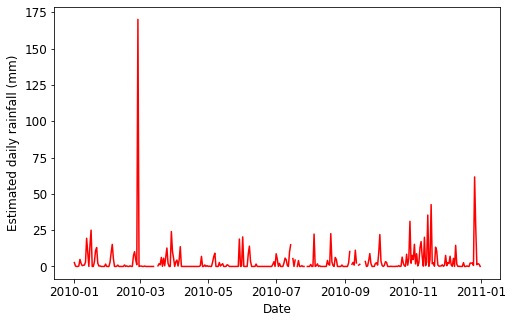

In [57]:
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax1.plot(dates, df_wxDarksky_daily['rainfallEstimate'].values, color='r')            

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Estimated daily rainfall (mm)', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)

In [58]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
          'November', 'December']
daynum = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

wx_varsSelected=['temperature','apparentTemperature','humidity','windSpeed','cloudCover',]
lineColors = ['r','m','c','g','b']

In [59]:
# load hourly load data 
hourly_df = pd.read_pickle('../project_data/intermediateDataIreland/CER_Data_Step6.hourly_df.pkl')
hourly_df

2010-01-01 00:00:00  2010-01-01 01:00:00  2010-01-01 02:00:00  \
user_id                                                                  
1002                  0.2340               0.0865               0.0555   
1014                  1.5060               0.7825               0.6985   
1018                  0.4710               0.4655               0.4515   
1022                  0.1980               0.2035               0.1405   
1027                  0.1115               0.0525               0.0370   
...                      ...                  ...                  ...   
7428                  0.3580               0.2915               0.1065   
7432                  0.5645               0.4420               0.2525   
7436                  0.4020               0.1325               0.1145   
7437                  0.2220               0.1255               0.1270   
7441                  0.0000               0.2345               0.2990   

         2010-01-01 03:00:00  2010-01-01 04:00:00  2010-01-01 05:00:00  \
user_id                                                                  
1002                  0.1055               0.0915               0.0480   
1014                  0.7385               0.6385               0.7615   
1018                  0.4640               0.4750               0.4730   
1022                  0.1280               0.1340               0.1155   
1027                  0.0370               0.0365               0.0370   
...                      ...                  ...                  ...   
7428                  0.1325               0.1275               0.1045   
7432                  0.2080               0.2065               0.1735   
7436                  0.1375               0.1295               0.1095   
7437                  0.2290               0.1460               0.1275   
7441                  0.1795               0.1150               0.0865   

         2010-01-01 06:00:00  2010-01-01 07:00:00  2010-01-01 08:00:00  \
user_id                                                                  
1002                  0.1230               0.1060               0.2745   
1014                  0.6845               0.7650               2.5470   
1018                  0.4830               0.7165               0.7205   
1022                  0.0505               0.0395               0.0515   
1027                  0.0365               0.0370               0.0915   
...                      ...                  ...                  ...   
7428                  0.1170               0.1780               0.1500   
7432                  0.1315               0.1305               0.1320   
7436                  0.1190               0.1280               0.1295   
7437                  0.1775               0.2595               0.1750   
7441                  0.2240               0.6980               0.6975   

         2010-01-01 09:00:00  2010-01-01 10:00:00  2010-01-01 11:00:00  \
user_id                                                                  
1002                  0.4495               0.9495               0.3070   
1014                  1.0510               0.8420               0.1475   
1018                  0.8405               2.0985               1.5795   
1022                  0.0350               0.1445               0.1055   
1027                  0.0360               0.5180               0.5180   
...                      ...                  ...                  ...   
7428                  0.1290               0.3810               0.1925   
7432                  0.1920               0.2050               0.7595   
7436                  0.1135               0.1265               0.1205   
7437                  0.1260               0.1750               0.2325   
7441                  0.4935               0.5500               0.6200   

         2010-01-01 12:00:00  2010-01-01 13:00:00  2010-01-01 14:00:00  \
user_id                                                                  
1002     

In [60]:
aggregateLoad = hourly_df.sum(axis=0)
aggregateLoad

2010-01-01 00:00:00    459.9240
2010-01-01 01:00:00    315.3425
2010-01-01 02:00:00    241.8140
2010-01-01 03:00:00    207.3360
2010-01-01 04:00:00    193.7125
                         ...   
2010-12-31 19:00:00    800.9225
2010-12-31 20:00:00    728.2215
2010-12-31 21:00:00    678.6815
2010-12-31 22:00:00    638.7405
2010-12-31 23:00:00    548.0200
Length: 8760, dtype: float64

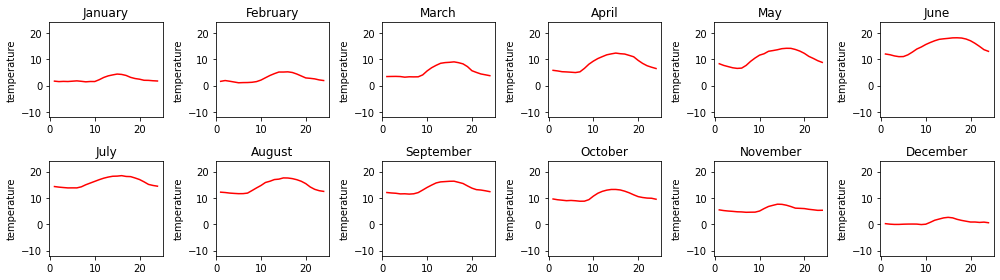

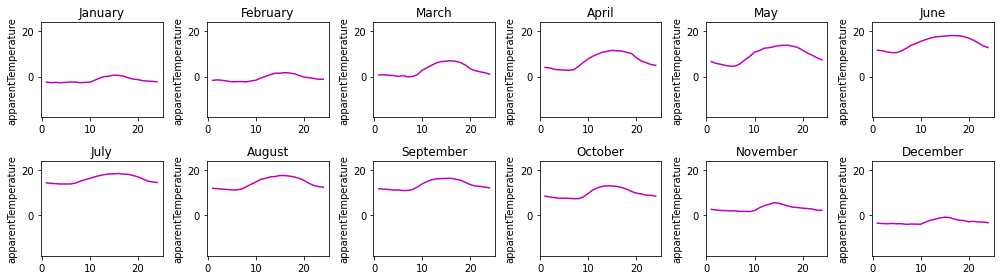

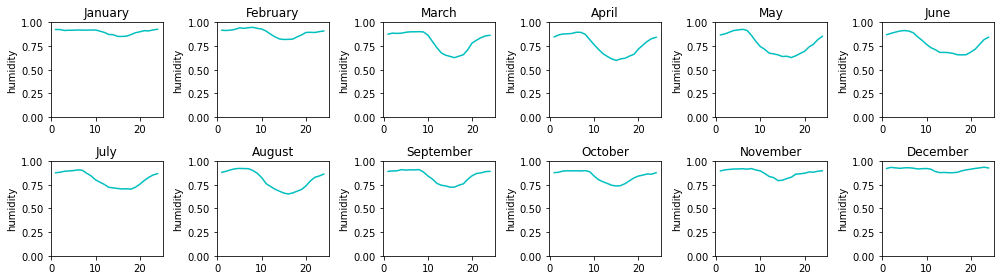

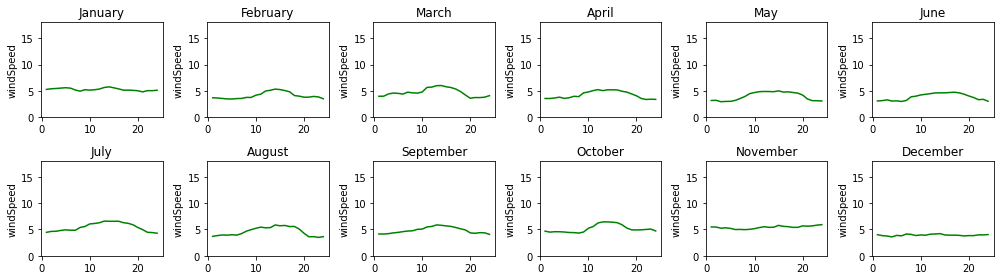

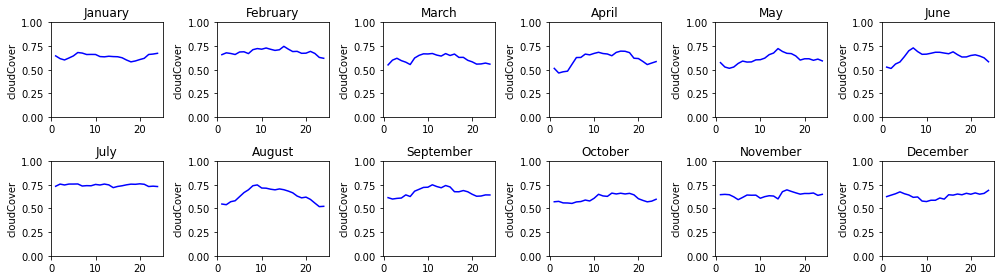

In [63]:
# plot weather variables for 2010 as line charts  :  plot average monthly weather profile (by day : x axis = hrs)

i=0  
for wx_var in wx_varsSelected:

    # extract wx_var as pandas series, pad NaN values and convert to np float64 array
    hourlyWx = df_wxDarksky[wx_var].interpolate(method='pad', limit=5).to_numpy(dtype='float64')      # pad up to 5 consecutive NaNs
    #print(hourlyWx)
   
    #get floor and ceiling for x axis range
    min_wx = math.floor(hourlyWx.min())
    max_wx = math.ceil(hourlyWx.max())
    
    
    # plot average monthly weather profile (by day : x axis = hrs)
    fig = plt.figure(figsize=(14,4))
    for j in range(len(months)):
        start = np.int(np.sum(daynum[0:j])*24)
        end = np.int(np.sum(daynum[0:j+1])*24)
        nDays = np.int((end-start)/24)
        hourlyWxReshape = hourlyWx[start:end].reshape(nDays,24)
        ax1 = fig.add_subplot(2,6,j+1)
        ax1.plot(np.arange(1,24.1), np.mean(hourlyWxReshape, axis=0),color=lineColors[i])
        ax1.set_ylabel(wx_var)
        ax1.set_title(months[j])
        ax1.set_ylim([min_wx,max_wx])
    fig.tight_layout()

    fname = '../project_data/figuresIreland/'+'WxVar_'+str(wx_var)+'_MonthlyProfiles.png'
    fig.savefig(fname, dpi=300, format='png',  bbox_inches='tight')  

    i+=1
    


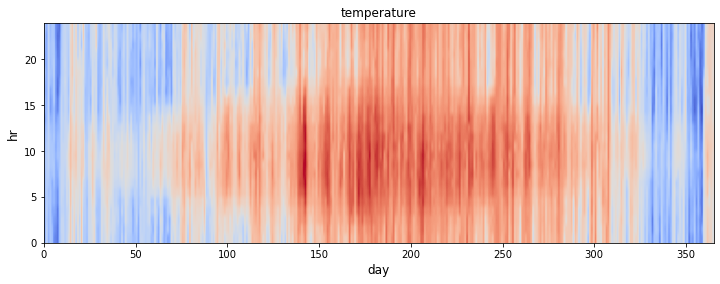

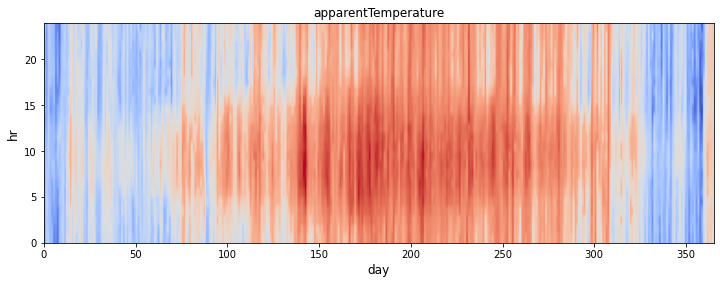

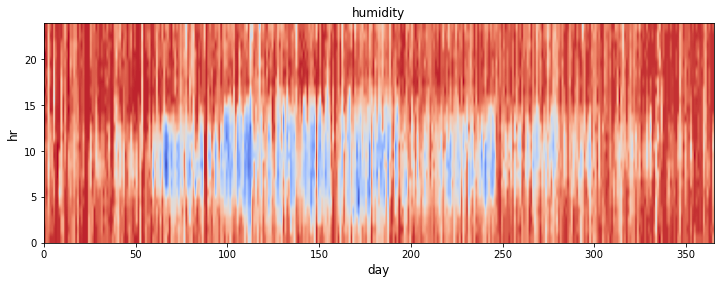

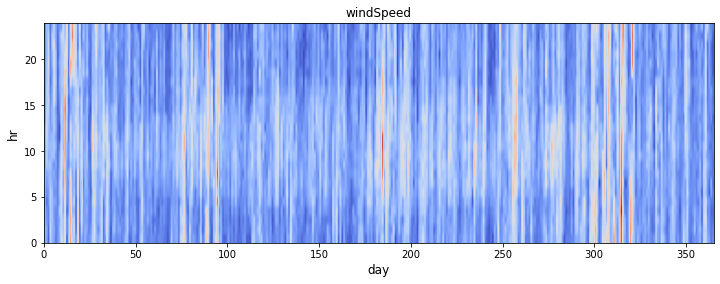

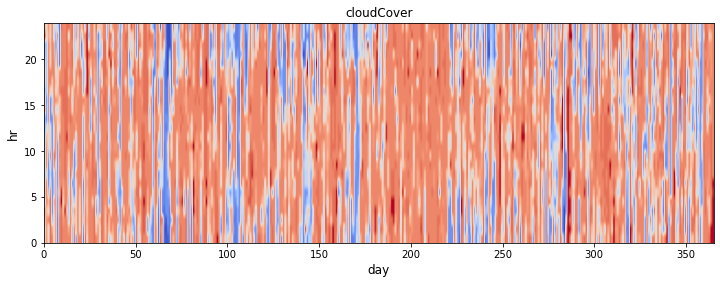

In [64]:
# plot selected weather variable for 2013 as heat maps
start=0
nDays=365

i=0
for wx_var in wx_varsSelected:
    fig = plt.figure(figsize=(12,12))

    # extract wx_var as pandas series, pad NaN values and convert to np float64 array
    hourlyWx = df_wxDarksky[wx_var].interpolate(method='pad', limit=5).to_numpy(dtype='float64')      # pad up to 5 consecutive NaNs
    end=hourlyWx.shape[0]
    
    hourlyWxReshape = hourlyWx[start:end].reshape(nDays,24)  
    hourlyWxReshape = np.transpose(hourlyWxReshape)  # transpose to 24 * nDays array   
    ax1 = fig.add_subplot(111)
    ax1.imshow(hourlyWxReshape,cmap = 'coolwarm',aspect=5, extent=[0,365,0,24])  
    tick_spacing = 1
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax1.set_title(wx_var)
    ax1.set_xlabel('day', fontsize=12)
    ax1.set_ylabel('hr', fontsize=12)
    fname = '../project_data/figuresIreland/'+'WxVar_'+str(wx_var)+'_heatmap.png'
    fig.savefig(fname, dpi=300, format='png',  bbox_inches='tight')
    i+=1
 

In [65]:
wx_varsSelected

['temperature', 'apparentTemperature', 'humidity', 'windSpeed', 'cloudCover']

C:\Users\fmurphy\Miniconda3\envs\fm_ANN\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fmurphy\Miniconda3\envs\fm_ANN\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fmurphy\Miniconda3\envs\fm_ANN\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fmurphy\Miniconda3\envs\fm_ANN\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\fmurphy\Miniconda3\envs\fm_ANN\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


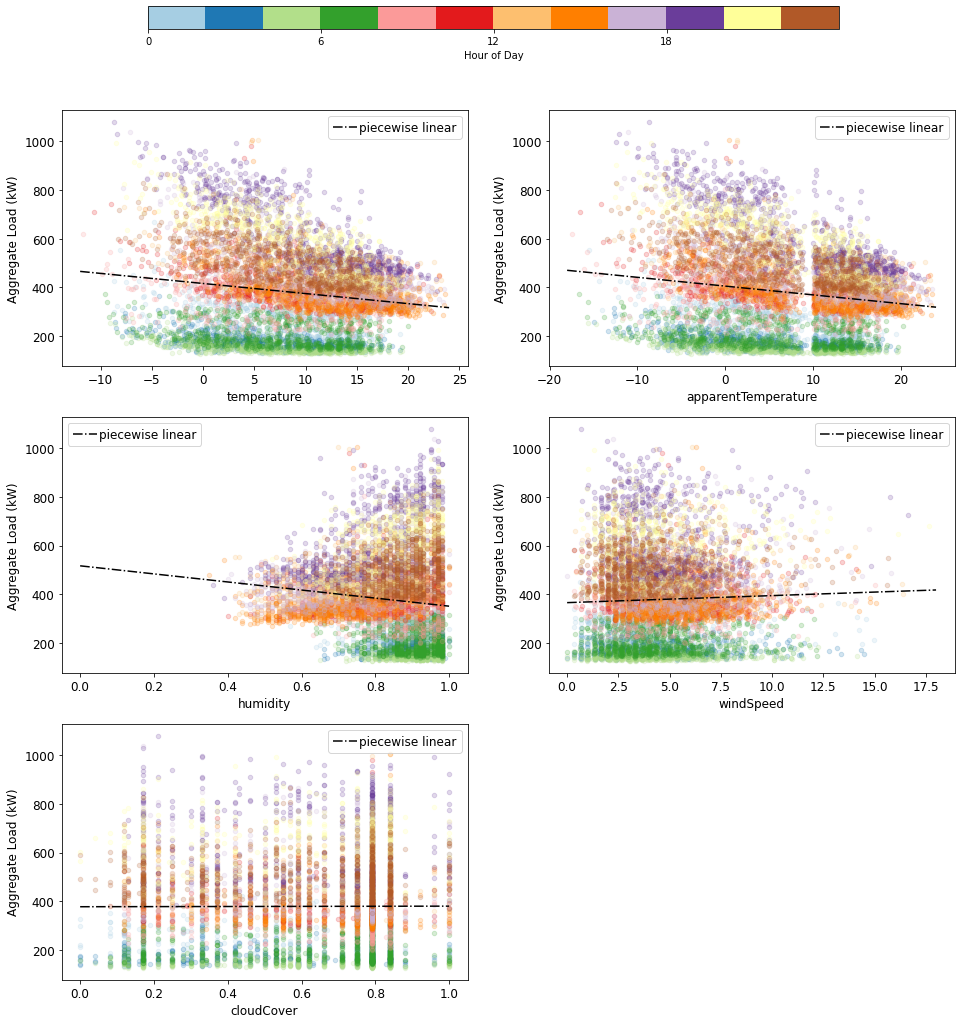

In [66]:
# plot load data v weather variable THIS TIME, PLOT COLOURS BY TIME OF DAY
cmOcc,cNorm,scalarMap3 = setColMap('Paired',minV=0,maxV=24)
start=0
nDays=365
fig = plt.figure(figsize=(16,16))

aggregateLoad = hourly_df.sum(axis=0)
loadReshape = (aggregateLoad.values).reshape(nDays,24) 

i=0
for wx_var in wx_varsSelected:
    # extract wx_var as pandas series, pad NaN values and convert to np float64 array
    hourlyWx = df_wxDarksky[wx_var].interpolate(method='pad', limit=5).to_numpy(dtype='float64')      # pad up to 5 consecutive NaNs
    end=hourlyWx.shape[0]
    hourlyWxReshape = hourlyWx[start:end].reshape(nDays,24)  
    #get floor and ceiling for x axis range
    min_wx = math.floor(hourlyWx.min())
    max_wx = math.ceil(hourlyWx.max())
           
    ax1 = fig.add_subplot(3,2,i+1)

    for k in range(24):
        cl = scalarMap3.to_rgba(k)
        cl = colors2.rgb2hex(cl)
        ax1.scatter(hourlyWxReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.2,color=cl)  # scatter plot aggregated (across users) consumption per hr v hourly weather variable
   
    # Least squares fit f,to data: piecewise linear curve (scipy) ; return 1)optimal fit as a tuple and 2)covariance
    p , e = optimize.curve_fit(piecewise_linear, hourlyWx,hourly_df.sum(axis=0))                                                                              
    #print("Optimal fit parameters: ",p)
    xd = np.linspace(min_wx,max_wx,101)
    ax1.plot(xd, piecewise_linear(xd, *p), color='k', linestyle='-.')    # line plot linear fit against dependent variable 

    ax1.set_xlabel(wx_var, fontsize=12)
    ax1.set_ylabel('Aggregate Load (kW)', fontsize=12)
    ax1.tick_params(axis='both', labelsize=12)

    proxys = [ ]
    proxys.append( mlines.Line2D([], [], color='k', linestyle='-.') )  # legend line style : https://matplotlib.org/tutorials/intermediate/legend_guide.html

    plt.legend(proxys, ['piecewise linear'],ncol=1, fontsize=12, handletextpad=0.2)
    
    
    fname = '../project_data/figuresIreland/'+'WxVar_'+str(wx_var)+'_hourlyload_predictor.png'
    fig.savefig(fname, dpi=300, format='png',  bbox_inches='tight')
    i+=1

cbar_ax = plt.axes([0.2, 0.95, 0.6, 0.02])   # xmin, ymin  (coords bottom left corner), dx, and dy (width, height) 
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,24,6), orientation='horizontal')
cbar.set_label('Hour of Day', rotation=0,position=(0.5,1.1))  #labelpad=5,


min -12, max 24


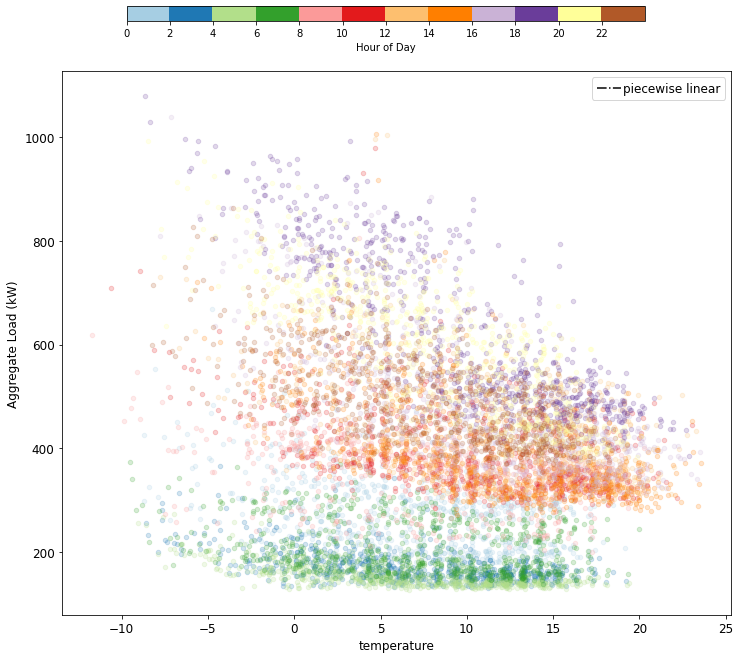

In [67]:
# plot load data v temperature  
cmOcc,cNorm,scalarMap3 = setColMap('Paired',minV=0,maxV=24)
fig = plt.figure(figsize=(12,10))
aggregateLoad = hourly_df.sum(axis=0)
loadReshape = (aggregateLoad.values).reshape(nDays,24) 
nDays=365


nightTime = np.asarray([23,0,1,2,3,4,5,6])   # ie 2300 to 0700
earlyMorn = np.asarray([7,8,9])              # 0700 to 1000
dayTime = np.asarray([10,11,12,13,14,15])    # 1000 to 1600
eveningTime = np.asarray([16,17,18,19,20,21,22,23])   #1600 to 0000   OVERLAPS WITH nightTime
timeLists = [nightTime, earlyMorn, dayTime, eveningTime]   # list of lists
lineStyles = ['-','-.',':','--']

i=0
wx_var='temperature'
hourlyWx = df_wxDarksky[wx_var].interpolate(method='pad', limit=5).to_numpy(dtype='float64')      # pad up to 5 consecutive NaNs
hourlyWxReshape = hourlyWx.reshape(nDays,24)

#get floor and ceiling for x axis range
min_wx = math.floor(hourlyWx.min())
max_wx = math.ceil(hourlyWx.max())
print("min {0}, max {1}".format(min_wx,max_wx))

ax1 = fig.add_subplot(111)

for k in range(24):
    cl = scalarMap3.to_rgba(k)
    cl = colors2.rgb2hex(cl)
    ax1.scatter(hourlyWxReshape[:,k],loadReshape[:,k],marker='o',s=20,alpha=0.2,color=cl)  # scatter plot aggregated (across users) consumption per hr v hourly weather variable

# Least squares fit f,to data: piecewise linear curve (scipy) ; return 1)optimal fit as a tuple and 2)covariance


# fit polynomial to (aggregate load v daylight length) for each half of year
for k in range(4):
    coefs = poly.polyfit(hourlyWxReshape[:,timeLists[k]].flatten(),loadReshape[:,timeLists[k]].flatten(), 2)  # lsq quadratic fit
    ffit = poly.polyval(xd, coefs)       # numpy.polyval - Evaluate a polynomial (coefs) at specific values (xd)
    #ax1.plot(xd, ffit, color='k',ls=lineStyles[k],alpha=1)        # plot  ffit 


ax1.set_xlabel(wx_var, fontsize=12)
ax1.set_ylabel('Aggregate Load (kW)', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)

proxys = [ ]
proxys.append( mlines.Line2D([], [], color='k', linestyle='-.') )  # legend line style : https://matplotlib.org/tutorials/intermediate/legend_guide.html

plt.legend(proxys, ['piecewise linear'],ncol=1, fontsize=12, handletextpad=0.2)


fname = '../project_data/figuresIreland/'+'WxVar_'+str(wx_var)+'_hourlyload_predictor.png'
fig.savefig(fname, dpi=300, format='png',  bbox_inches='tight')
i+=1

cbar_ax = plt.axes([0.2, 0.95, 0.6, 0.02])   # xmin, ymin  (coords bottom left corner), dx, and dy (width, height) 
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,24,2), orientation='horizontal')
cbar.set_label('Hour of Day', rotation=0,position=(0.5,1.1))  #labelpad=5,


** look at load profiles **

In [68]:
aggregateLoad = hourly_df.sum(axis=0)    # sum each column ie aggregate of all users at each time 
print("Aggregate Load: \n",aggregateLoad)
annualUserLoad=pd.DataFrame(hourly_df.sum(axis=1),columns=['Annual Load'])
print("Annual user load: \n",annualUserLoad)
nUsers=annualUserLoad.shape[0]
print(nUsers)

Aggregate Load: 
 2010-01-01 00:00:00    459.9240
2010-01-01 01:00:00    315.3425
2010-01-01 02:00:00    241.8140
2010-01-01 03:00:00    207.3360
2010-01-01 04:00:00    193.7125
                         ...   
2010-12-31 19:00:00    800.9225
2010-12-31 20:00:00    728.2215
2010-12-31 21:00:00    678.6815
2010-12-31 22:00:00    638.7405
2010-12-31 23:00:00    548.0200
Length: 8760, dtype: float64
Annual user load: 
          Annual Load
user_id             
1002       1818.2700
1014       5114.1950
1018       8394.2755
1022       3050.6365
1027       1969.5210
...              ...
7428       2642.7220
7432       3344.5585
7436       4771.6485
7437       5726.9660
7441       3393.8300

[778 rows x 1 columns]
778


In [69]:
annualUserLoad.std(axis=0).values

array([2268.98772062])

In [70]:
print("Average household annual consumption: {0} CER residential users: \n {1} "\
      .format(nUsers,annualUserLoad.sum(axis=0)/nUsers))
print(" std deviation of annual consumption is : {0} \n".format(annualUserLoad.std(axis=0)))

Average household annual consumption: 778 CER residential users: 
 Annual Load    4275.663039
dtype: float64 
 std deviation of annual consumption is : Annual Load    2268.987721
dtype: float64 



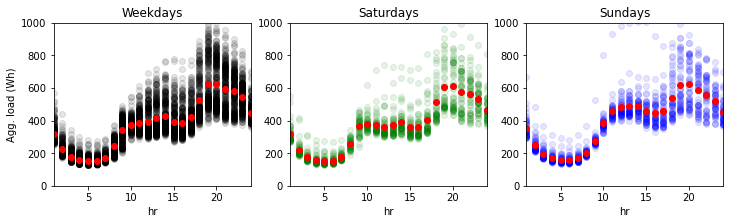

In [71]:
fig=PlotLoadByDaysOfWeek(aggregateLoad,'Agg. load (Wh)',1000)
fname = '../project_data/figuresIreland/AggregateLoad.png'
fig.savefig(fname, dpi=300, format='png',  bbox_inches='tight')

** Test Persistance Model over 24h lag for Weekdays and weekends **

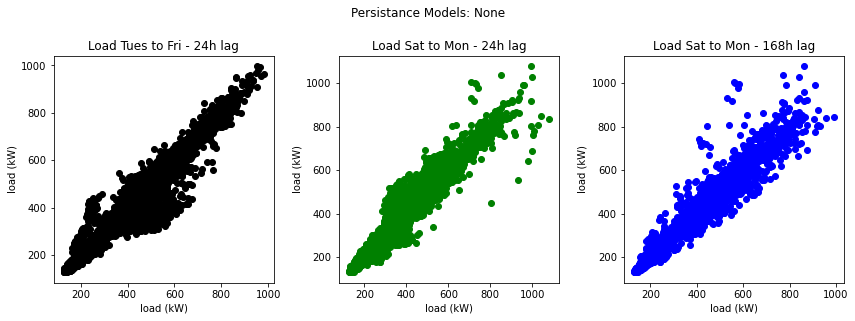

In [74]:
# plot peristance model for Hourly data
nDays=365
persistScatterPlot(aggregateLoad,smplsPerDay=24,nDays=365,FigTitle='CER_1H_PersistanceModelPredictor')